In [33]:
#pip install scikit-learn


Predicted Retail Sales for 2021: 59,923,295 MWh
Actual Retail Sales for 2021: 59,303,974 MWh
Prediction Error: 619,321 MWh

Predicted Retail Sales for 2022: 61,421,041 MWh
Actual Retail Sales for 2022: 59,682,719 MWh
Prediction Error: 1,738,322 MWh

Predicted Retail Sales for 2023: 60,375,777 MWh
Actual Retail Sales for 2023: 57,033,085 MWh
Prediction Error: 3,342,692 MWh

Mean Absolute Error (MAE): 1,900,112 MWh
Root Mean Squared Error (RMSE): 2,204,458 MWh
Mean Absolute Percentage Error (MAPE): 3.27%

Cross-Validation Results (MAE for each fold): [2581510.1        2507970.08        684431.75       1786903.03399999
 3342692.014     ]
Average MAE across all folds: 2,180,701 MWh


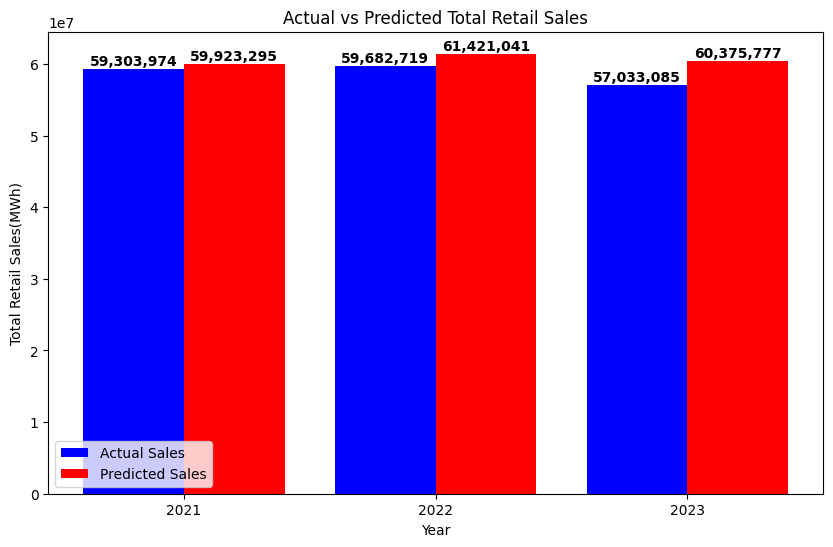

In [34]:
# Random Forest Regressor for Revenue Prediction (combined graph)

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Load data from CSV
df = pd.read_csv(r'C:\Users\Kanis\OneDrive\Documents\EnergyPredictingML\data\processed\mllearningdata.csv')


# sort by year
df = df.sort_values(by='Year')

# Columns to check after print inspection 
years = [2021, 2022, 2023]
predicted_sales = []
actual_sales = []

for year in years:
    train_data = df[df["Year"] < year]
    X_train = train_data[["Avg Price(cents/kWh)"]]  
    y_train = train_data["Total retail sales(MWh)"]  
    
    # Test data 
    test_data = df[df["Year"] == year][["Avg Price(cents/kWh)"]]
    actual_sales.append(df[df["Year"] == year]["Total retail sales(MWh)"].values[0])
    
    # normalize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(test_data)
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    predicted_value = model.predict(X_test_scaled)[0]
    predicted_sales.append(predicted_value)
    
    print(f"Predicted Retail Sales for {year}: {predicted_value:,.0f} MWh")
    print(f"Actual Retail Sales for {year}: {actual_sales[-1]:,.0f} MWh")
    print(f"Prediction Error: {abs(actual_sales[-1] - predicted_value):,.0f} MWh\n")

# visualization
plt.figure(figsize=(10, 6))
x = np.arange(len(years))  # X positions for bars
width = 0.4  # Bar width

plt.bar(x - width/2, actual_sales, width, label="Actual Sales", color='blue')
plt.bar(x + width/2, predicted_sales, width, label="Predicted Sales", color='red')

plt.xlabel("Year")
plt.ylabel("Total Retail Sales(MWh)")
plt.title("Actual vs Predicted Total Retail Sales")
plt.xticks(ticks=x, labels=years)
plt.legend()

# labels to bars
for i in range(len(years)):
    plt.text(i - width/2, actual_sales[i] + 500000, f"{actual_sales[i]:,.0f}", ha='center', fontsize=10, fontweight='bold')
    plt.text(i + width/2, predicted_sales[i] + 500000, f"{predicted_sales[i]:,.0f}", ha='center', fontsize=10, fontweight='bold')

# calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(actual_sales, predicted_sales)
print(f"Mean Absolute Error (MAE): {mae:,.0f} MWh")

# calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_sales, predicted_sales))
print(f"Root Mean Squared Error (RMSE): {rmse:,.0f} MWh")

# calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(actual_sales, predicted_sales)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


# drop rows with missing values in relevant columns
df_cleaned = df[["Avg Price(cents/kWh)", "Total retail sales(MWh)"]].dropna()

# Cross-validation
X = df_cleaned[["Avg Price(cents/kWh)"]]
y = df_cleaned["Total retail sales(MWh)"]

# normalize 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# time series cross-validation (no shuffle)
kf = KFold(n_splits=5, shuffle=False)
cv_results = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error')

cv_results = -cv_results  # convert to positive MAE

print(f"\nCross-Validation Results (MAE for each fold): {cv_results}")
print(f"Average MAE across all folds: {cv_results.mean():,.0f} MWh")

# plot
plt.show()


Evaluation Meathod:
MAE(Mean Absolute Error): MAE gives us an averge of how much the prediction skewed form the actual values that we saw with the visualization. The MAE is useful in this scienario to interperate metrics becase it report the error i the same units as the original, which makes it easier to understand how far off predictions were on average. 

RMSE(Root Mean Squared Error): This method  gives higher weight to the larger errors, which helps to identify how severe occasional large deviations in the data are. 

Mean Absolute Percentage Error(MAE): This meatmethod hod piggybacks off of MAE by giving the model the error as a percentage, this is useful for understanding the models accuracy in relative terms. 

Model Performance Analysis:
The Mean Absolute Error (MAE) of 1,900,112 MWh indicates that the model’s predictions, on average, are off by about 1.9 million MWh. Considering that Maryland's annual retail electricity sales are around 57 million MWh, this error represents a 3–4% deviation. While this may be acceptable for broad forecasting purposes, it could fall short for operational planning or policy decision-making that requires more precision.

Cross-validation results further reflect inconsistencies in the model's performance. MAE values ranged from approximately 684,000 MWh to over 3.34 million MWh depending on the data split. For example, the model performed relatively well in 2021, with a prediction error of just over 619,000 MWh. However, it underperformed significantly in 2023, with a prediction error exceeding 3.3 million MWh. This suggests the model is sensitive to the years chosen for training and testing, which raises concerns about its generalizability and stability over time.

The Root Mean Squared Error (RMSE) came out to 2.2 million MWh, slightly higher than the MAE. This confirms the presence of larger errors in some years, particularly 2023. RMSE is valuable in this context because it highlights the severity of large individual prediction errors that MAE alone might downplay.

The Mean Absolute Percentage Error (MAPE) was 3.27%, meaning the model’s predictions, on average, were within 3.27% of the actual values. This is reasonable for large-scale energy forecasting, but it may still be too imprecise for use in scenarios where exact load estimates or budget forecasts are required.

Strengths:
One of the strengths of this project is the simplicity and clarity of the modeling approach. The Random Forest model is easy to understand and was implemented with standard preprocessing steps, such as data scaling. The use of clear and interpretable performance metrics like MAE, RMSE, and MAPE makes the results accessible to a wide audience. The visualizations also add value by helping to show how close the predicted values are to the actual retail electricity sales, especially for earlier years like 2021. These factors make the model useful as a general forecasting tool, particularly for near-term predictions.

Weaknesses:
Despite these strengths, there are several limitations. The small dataset—only three years of target values—restricts the model’s ability to detect longer-term patterns or trends. Additionally, relying on default model parameters may lead to underfitting or overfitting. MAE alone doesn’t indicate whether the model consistently overpredicts or underpredicts, and it doesn’t penalize large errors as strongly as RMSE. The significant variation in performance across years also reduces confidence in the model’s ability to generalize to future years. The degradation in accuracy over time, especially in 2023, could indicate temporal drift, where changes in external conditions (such as climate, policy, or population growth) make newer data behave differently from older data.

Future:
To improve the model, I would suggest incorporating additional explanatory variables. Features such as temperature, population growth, and industrial activity could help the model capture important drivers of electricity consumption. Including economic indicators like unemployment or industrial output may also improve accuracy by providing context for business-related energy use. Hyperparameter tuning could further refine the model, helping it adapt better to different types of data and reduce performance variability. Expanding the dataset to include more years would also allow the model to learn more stable, long-term trends.

Conclusion:
Overall, the current model provides a solid starting point for forecasting retail electricity sales in Maryland. It performs reasonably well in earlier years and offers interpretable results that are suitable for high-level planning. However, the inconsistency in prediction accuracy and the sharp increase in error for 2023 indicate that further refinement is needed. By adding more data and incorporating external features, the model could evolve into a more accurate and reliable tool for forecasting future electricity demand.


Predicted Revenue for 2021: 3,601,029
Actual Revenue for 2021: 3,669,204
Prediction Error: 68,175
Cross-validation MSE scores for 2021: [2.05931454e+10 1.51556670e+09 8.82137590e+09]
Average cross-validation MSE for 2021: 10310029348.86

Predicted Revenue for 2022: 3,685,103
Actual Revenue for 2022: 4,057,913
Prediction Error: 372,810
Cross-validation MSE scores for 2022: [5.68271192e+09 1.09745466e+10 4.64786199e+09]
Average cross-validation MSE for 2022: 7101706818.52

Predicted Revenue for 2023: 3,901,558
Actual Revenue for 2023: 4,333,163
Prediction Error: 431,605
Cross-validation MSE scores for 2023: [1.78176959e+10 3.89978253e+10 1.38987072e+11]
Average cross-validation MSE for 2023: 65267531199.04


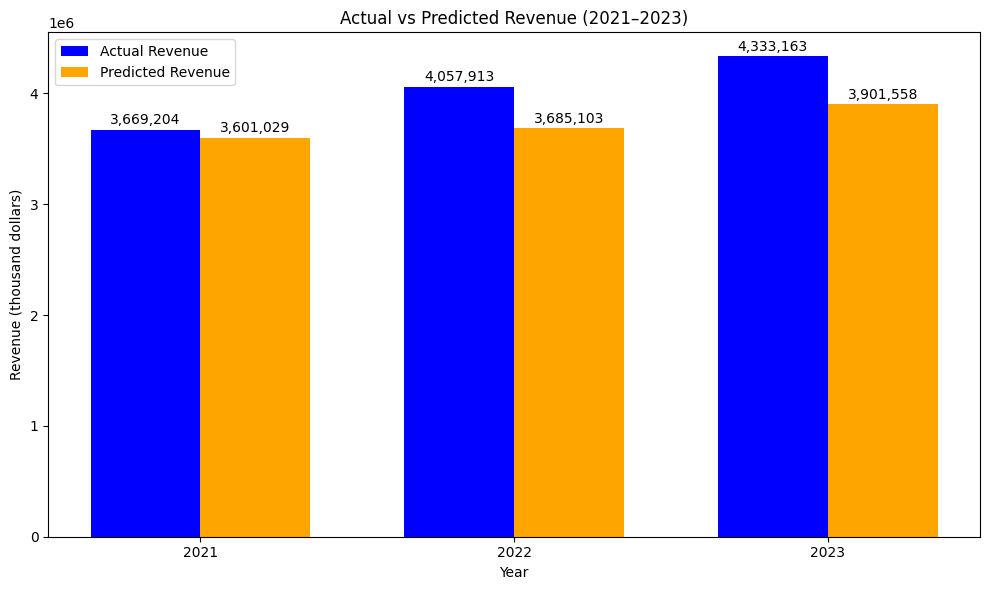


Mean Absolute Error (MAE): 290,863 thousand dollars
Root Mean Squared Error (RMSE): 331,621 thousand dollars
Mean Absolute Percentage Error (MAPE): 7.00%

Summary of Results:
Year 2021 - Predicted Revenue: 3601029, Actual Revenue: 3669204, Prediction Error: 68175
Year 2022 - Predicted Revenue: 3685103, Actual Revenue: 4057913, Prediction Error: 372810
Year 2023 - Predicted Revenue: 3901558, Actual Revenue: 4333163, Prediction Error: 431605


In [ ]:
# Random Forest Regressor for Revenue Prediction (combined graph)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

# Load data 
df = pd.read_csv(r'C:\Users\Kanis\OneDrive\Documents\EnergyPredictingML\data\processed\mllearningdata.csv')

df = df.sort_values(by='Year')


# define prediction years
years_to_predict = [2021, 2022, 2023]
predictions = []
actuals = []
results = []

# loop through each year for prediction
for year in years_to_predict:
    train_data = df[df["Year"] <= year - 1]
    X_train = train_data[["Avg Price(cents/kWh)", "Total retail sales(MWh)"]]
    y_train = train_data["Revenue(thousand dollars)"]

    test_data = df[df["Year"] == year][["Avg Price(cents/kWh)", "Total retail sales(MWh)"]]
    actual_revenue = df[df["Year"] == year]["Revenue(thousand dollars)"].values[0]

    # standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(test_data)

    # Train  
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predict
    predicted_revenue = model.predict(X_test_scaled)[0]
    predictions.append(predicted_revenue)
    actuals.append(actual_revenue)

    results.append({
        "Year": year,
        "Predicted Revenue": predicted_revenue,
        "Actual Revenue": actual_revenue,
        "Prediction Error": abs(actual_revenue - predicted_revenue)
    })

    print(f"\nPredicted Revenue for {year}: {predicted_revenue:,.0f}")
    print(f"Actual Revenue for {year}: {actual_revenue:,.0f}")
    print(f"Prediction Error: {abs(actual_revenue - predicted_revenue):,.0f}")

    # cross-validation (3-fold)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='neg_mean_squared_error')
    cv_mse_scores = -cv_scores
    average_cv_mse = np.mean(cv_mse_scores)

    print(f"Cross-validation MSE scores for {year}: {cv_mse_scores}")
    print(f"Average cross-validation MSE for {year}: {average_cv_mse:.2f}")

# Visualization
x = np.arange(len(years_to_predict))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, actuals, width, label='Actual Revenue', color='blue')
plt.bar(x + width/2, predictions, width, label='Predicted Revenue', color='orange')

plt.xlabel("Year")
plt.ylabel("Revenue (thousand dollars)")
plt.title("Actual vs Predicted Revenue (2021–2023)")
plt.xticks(x, years_to_predict)
plt.legend()

# labels
for i in range(len(years_to_predict)):
    plt.text(x[i] - width/2, actuals[i] + 50000, f"{actuals[i]:,.0f}", ha='center', fontsize=10)
    plt.text(x[i] + width/2, predictions[i] + 50000, f"{predictions[i]:,.0f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# error Metrics
mae = mean_absolute_error(actuals, predictions)
print(f"\nMean Absolute Error (MAE): {mae:,.0f} thousand dollars")

rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:,.0f} thousand dollars")

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(actuals, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# summary
print("\nSummary of Results:")
for r in results:
    print(f"Year {r['Year']} - Predicted Revenue: {r['Predicted Revenue']:.0f}, "
          f"Actual Revenue: {r['Actual Revenue']:.0f}, "
          f"Prediction Error: {r['Prediction Error']:.0f}")


Analysis
Mean Squared Error (MSE):
MSE measures the average of the squared differences between predicted and actual values. This method penalizes large errors more than smaller ones, making it sensitive to outliers. A lower MSE indicates better predictive accuracy, while a high MSE suggests large deviations in prediction or poor model generalization.

Mean Absolute Percentage Error(MAE):
MAE shows the average magnitude of errors, without emphasizing larger errors the way MSE does. It gives a more general sense of model performance without being overly affected by outliers.

For 2023, the MSE is notably high, which indicates that at least one fold had a large error—something that’s also reflected in the visualizations. While the MAE remains moderate, the skew suggests that the model’s predictions may be inconsistent and particularly sensitive to outliers in recent years. This large error could reflect unpredictable shifts in energy demand or price spikes not captured by the model. Such discrepancies are significant when it comes to energy budgeting or policy planning.

The jump in error for 2023 might be due to post-COVID shifts in energy usage patterns, inflation, policy changes, or macroeconomic factors that weren’t included in the dataset. This highlights the need to incorporate more time-sensitive features to improve predictive accuracy for recent and future years.

Strengths:
Cross-validation shows that the model is capable of providing error estimates for each year. The average MSE for 2021 (10.31 billion) and 2022 (7.1 billion) suggests that the model performs reasonably well during those years, with smaller errors compared to 2023. This implies that the model can predict revenue trends fairly accurately for earlier years. Since the MSE values are not excessively high in 2021 and 2022, this could be promising when forecasting future trends.

Weaknesses:
However, the model shows significant variability in its error for 2023, with MSE values ranging from 17.8 billion to over 138.9 billion. This is resulting in an average MSE of 65.27 billion. This large error indicates that the model struggles to predict revenue accurately for 2023, likely due to increased complexity in the data or missing key features.

The model's performance appears to decline as the prediction year moves further from the training period, which could signal overfitting to earlier years or insufficient training data. The wide range of MSE values also suggests poor generalization to years beyond the training set. This drastic shift may be a result of rapidly changing conditions.

Conclusion:
Overall, the MSE and cross-validation results suggest that additional features need to be considered for more accurate predictions. Without these, the model risks producing skewed and unreliable results. For future research, I plan to tune the Random Forest model’s hyperparameters to achieve more consistent performance across folds. I’ll also consider adding new features or transforming existing ones to improve the model’s predictive power.

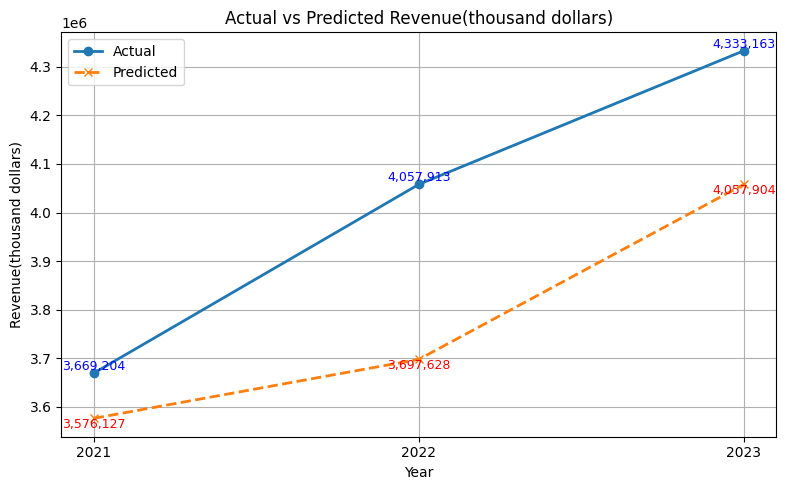

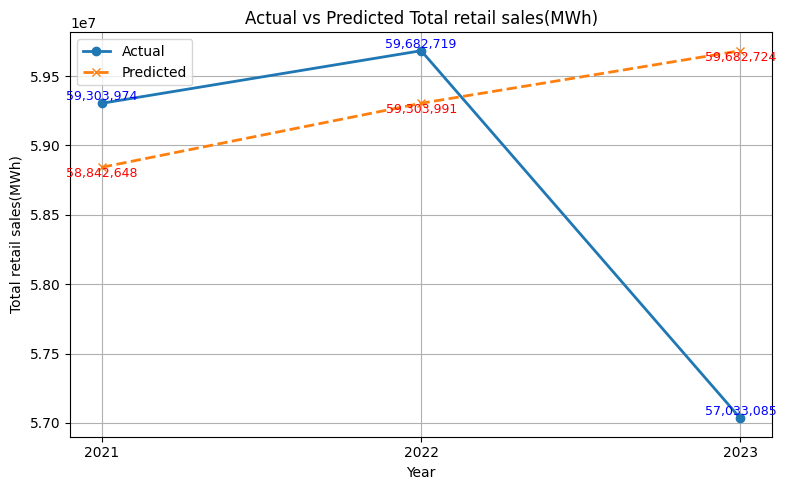

MAE for Revenue(thousand dollars): 242,873.56
MAE for Total retail sales(MWh): 1,163,231.13

Revenue(thousand dollars) - Actual vs Predicted:
Year   |          Actual |       Predicted
-------------------------------------------
2021   |       3,669,204 |       3,576,127
2022   |       4,057,913 |       3,697,628
2023   |       4,333,163 |       4,057,904

Total retail sales(MWh) - Actual vs Predicted:
Year   |          Actual |       Predicted
-------------------------------------------
2021   |      59,303,974 |      58,842,648
2022   |      59,682,719 |      59,303,991
2023   |      57,033,085 |      59,682,724

Performance Metrics for Revenue(thousand dollars):
  MAE:  242,873.56
  RMSE: 267,230.07
  MAPE: 5.92%

Performance Metrics for Total retail sales(MWh):
  MAE:  1,163,231.13
  RMSE: 1,568,103.45
  MAPE: 2.02%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv(r'C:\Users\Kanis\OneDrive\Documents\EnergyPredictingML\data\processed\mllearningdata.csv')

targets = ["Revenue(thousand dollars)", "Total retail sales(MWh)"]

results = {t: {"actual": [], "predicted": []} for t in targets}

# targets to predict
years = [2021, 2022, 2023]

df = df.sort_values(by='Year').reset_index(drop=True)

# sequential forecasting from year index 3 to 5
for i in range(3, 6):
    train_df = df.iloc[:i]
    test_df = df.iloc[[i]]

    for target in targets:
        X_train = train_df.drop(columns=targets)
        y_train = train_df[target]
        X_test = test_df.drop(columns=targets)
        y_test = test_df[target]

        # scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # train model
        model = GradientBoostingRegressor(random_state=42)
        model.fit(X_train_scaled, y_train)

        # predict
        y_pred = model.predict(X_test_scaled)

        # results
        results[target]["actual"].append(y_test.values[0])
        results[target]["predicted"].append(y_pred[0])

# Visualization 
for target in targets:
    actual = results[target]["actual"]
    predicted = results[target]["predicted"]

    plt.figure(figsize=(8, 5))
    plt.plot(years, actual, marker='o', label="Actual", linewidth=2)
    plt.plot(years, predicted, marker='x', label="Predicted", linestyle='--', linewidth=2)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Year")
    plt.ylabel(target)
    plt.xticks(years)

    # Annotate actual values
    for x, y in zip(years, actual):
        plt.text(x, y, f'{y:,.0f}', va='bottom', ha='center', fontsize=9, color='blue')

    # annotate predicted values
    for x, y in zip(years, predicted):
        plt.text(x, y, f'{y:,.0f}', va='top', ha='center', fontsize=9, color='red')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# MAE \
for target in targets:
    mae = mean_absolute_error(results[target]["actual"], results[target]["predicted"])
    print(f"MAE for {target}: {mae:,.2f}")

#  results 
for target in targets:
    print(f"\n{target} - Actual vs Predicted:")
    print(f"{'Year':<6} | {'Actual':>15} | {'Predicted':>15}")
    print("-" * 43)
    for year, actual, pred in zip(years, results[target]["actual"], results[target]["predicted"]):
        print(f"{year:<6} | {actual:>15,.0f} | {pred:>15,.0f}")

# MAPE 
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# calculate and print RMSE and MAPE
for target in targets:
    actual = results[target]["actual"]
    predicted = results[target]["predicted"]

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)

    print(f"\nPerformance Metrics for {target}:")
    print(f"  MAE:  {mean_absolute_error(actual, predicted):,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  MAPE: {mape:.2f}%")


Evaluation Meathod:
MAE(Mean Absolute Error): MAE gives us an averge of how much the prediction skewed form the actual values that we saw with the visualization. The MAE is useful in this scienario to interperate metrics becase it report the error i the same units as the original, which makes it easier to understand how far off predictions were on average. 

RMSE(Root Mean Squared Error): This method  gives higher weight to the larger errors, which helps to identify how severe occasional large deviations in the data are. 

Mean Absolute Percentage Error(MAE): This method  piggybacks off of MAE by giving the model the error as a percentage, this is useful for understanding the models accuracy in relative terms. 

The revenue prediction:
The MAE for revenue predictions was approximately $243 million, meaning the model’s predictions were off by that amount on average. This is a significant error in real-world terms, especially when applied to utility budgets or energy policy. The fact that the model underestimated revenue in all three years, particularly in 2022 and 2023, suggests potential underfitting, the model may not be capturing recent trends or spikes in energy pricing. This could be due to a lack of relevant features such as economic changes, fuel prices, or seasonal demand surges. With the analysis of RMSE and MAPE, we can take more closer of a look. MAPE of 5.92% tells us that the predictions within around 6% of the actual values, from the visualizations we can see this is a reasonable percentage. 

Total retail sales prediction:
The MAE for total electricity sales was 1.16 million megawatt-hours, which is substantial, though relatively close in the earlier years. For 2021 and 2022, the predictions closely followed the actual data, indicating a good short-term forecasting ability. However, in 2023, the prediction overshot the actual value largely compared to the other two. This mismatch is visible in the "Actual vs. Predicted Total Retail Sales" graph, where the earlier trends are followed well, but diverge significantly in the final year.

This suggests the model may perform better when forecasting near-term values but loses accuracy as the prediction horizon extends. The high MAE in 2023 also reflects that the model may not generalize well as conditions change, further indication that more data will be needed to support any results that are found by the ML model. It also reflects that more factors need to be inputted to consider the other affecting aspects of the data that is not controllable. 
When looking at the RMSE and MAPE analysis we can make further observations. 2% MAPE reflects that the model performed well in predicting electriity consumption, with an average error just above 1 million MWh. The results form 2023 has the largest deviation, whcih may be due to unexpected changes in using patterns or other external factors that was not captured by the model/data, like weather. 

Overall Analysis:
The predictive model shows moderately strong performance in forecasting both revenue and total retail electricity sales, with tolerable levels of error depending on the use case. However, performance varies across years and metrics.

Strengths: Models performs reasonably well, easpecially for retail sales. Low MAPE suggests that it is sustainable for mainly short term forecasting. 

Weaknesses: RMSE values reflects that occasional large prediction errors still exist. The model struggles slightly with spikes in revenue, indicating the need for more recent features or tuning. 